# README



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import plotly.express as px
import plotly.graph_objects as go


In [ ]:
# Reading the CSV files
articles_df = pd.read_csv('data/articles.leptospirosis.csv')
authors_df = pd.read_csv('data/authors.leptospirosis.csv')
paper_counts_df = pd.read_csv('data/paper_counts.csv')

display(articles_df.head())
display(authors_df.head())
display(paper_counts_df.head())

# Check the data types and basic structure of the dataframes
print(articles_df.info())
print(authors_df.info())
print(paper_counts_df.info())

# Check for missing values in each dataset
print(articles_df.isnull().sum())
print(authors_df.isnull().sum())
print(paper_counts_df.isnull().sum())

In [ ]:
# Drop rows with missing values in specific columns
# Remove rows with missing values in the articles DataFrame
articles_df_cleaned = articles_df.dropna()
authors_df_cleaned = authors_df.dropna()
paper_counts_df_cleaned = paper_counts_df.dropna()

# Drop duplicate rows
articles_df.drop_duplicates(inplace=True)
authors_df.drop_duplicates(inplace=True)
paper_counts_df.drop_duplicates(inplace=True)

# Check if there are any missing values left
print(articles_df.isnull().sum())
print(authors_df.isnull().sum())

In [ ]:
# Check the data types of each column
# print(articles_df_cleaned.dtypes)

# Example of type conversion if needed
articles_df_cleaned.loc[:, 'Year'] = articles_df_cleaned['Year'].astype(int)

In [ ]:
num_topics = 6

# Combine the title and abstract into a single text column
articles_df['Text'] = articles_df['Title'].fillna('') + ' ' + articles_df['Abstract'].fillna('')

# Set up the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf_vectorizer.fit_transform(articles_df['Text'])

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get the topic distribution for each document
topic_distribution = lda.transform(X)

# Assign each document to its most likely topic
topic_assignments = topic_distribution.argmax(axis=1)

In [ ]:
# Step 2: Create a full name for each author
# Replace NaN values with an empty string and combine first name, last name, and initials
authors_df['FullName'] = authors_df['AuthorForename'].fillna('') + ' ' + authors_df['AuthorLastname'].fillna('')

# Step 3: Combine all authors for a given PMID
# Group by PMID and join authors' full names into a single string
author_fullnames = authors_df.groupby('PMID')['FullName'].apply(lambda x: ', '.join(x)).reset_index()

# Step 4: Extract topic distribution scores for each article
topic_distribution = lda.transform(X)

# Step 5: Extract top articles for each topic based on relevance scores
num_top_articles = 100  # Number of top articles to extract per topic

top_articles_per_topic = {}

for topic_idx in range(lda.n_components):
    # Skip topic 4 (index 3) as requested
    if topic_idx == 0 or topic_idx == 1 or topic_idx == 3:
        continue

    # Get the relevance scores for each article with respect to the current topic
    topic_scores = topic_distribution[:, topic_idx]

    # Get the indices of the top articles sorted by highest relevance
    top_article_indices = topic_scores.argsort()[-num_top_articles:][::-1]

    # Extract the titles and other info of the top articles for the current topic
    top_articles = articles_df.iloc[top_article_indices][['Title', 'Year', 'PMID']]

    # Extract authors' full names for the top articles
    top_articles['Authors'] = top_articles['PMID'].map(
        lambda pmid: author_fullnames[author_fullnames['PMID'] == pmid]['FullName'].values[0]
    )

    # Store the result in the dictionary
    top_articles_per_topic[topic_idx] = top_articles

# Step 6: Display the results for each topic and aggregate authors' names across all topics
all_authors_series = pd.Series(dtype='str')

for topic_idx, top_articles in top_articles_per_topic.items():
    print(f"Topic {topic_idx+1}:")
    display(top_articles[['Title', 'Authors', 'Year']])

    # Collect authors from each topic
    authors_series = top_articles['Authors'].str.split(', ', expand=True).stack()
    all_authors_series = pd.concat([all_authors_series, authors_series], ignore_index=True)

# Count the frequency of each author across all topics
authors_count_total = all_authors_series.value_counts().reset_index()
authors_count_total.columns = ['Author', 'Count']

# Step 7: Display the total counts of authors sorted by frequency
print("Total Author Frequency Across Topic 3,5,6:")
display(authors_count_total.head(20))


Topic 3:


,Title,Authors,Year
1289,Severe leptospirosis: treatment with intraveno...,"Kyle Minor, Arun Mohan",2013
3218,Case Report: An Imported Case of Severe Leptos...,"Takao Goto, Rentaro Oda, Yasuhiro Norisue, Nob...",2023
3254,Case report: Leptospirosis with multi-organ fa...,"Mariam Thalji, Hanan Qunibi, Loai Muhtasib, Ha...",2023
1031,Clinical and imaging manifestations of hemorrh...,"Edson Marchiori, Sílvia Lourenço, Sérgio Setúb...",2011
2012,Leptospirosis Presenting with Rapidly Progress...,"Pallavi Pothuri, Keerat Ahuja, Viki Kumar, Sha...",2016
...,...,...,...
1881,Acute Respiratory Distress Syndrome Manifested...,"Chen-Yi Liao, Ren-Jy Ben, Hau-Ming Wu, Shih-Ku...",2015
1496,Leptospirosis and dengue fever: a predictive m...,"Muralidhar D Varma, Seena Vengalil, Saraschand...",2014
70,[Febrile cytolysis disclosing hemorrhagic feve...,"E Rassiat, E Barrière, A Minello, J Jouve, P H...",2000
1115,Clinical manifestations of co-infection with m...,"Mohan Gurjar, Saurabh Saigal, Arvind K Baronia...",2011


Topic 5:


,Title,Authors,Year
30,Epidemiological trend of human leptospirosis i...,"L Ciceroni, E Stepan, A Pinto, P Pizzocaro, G ...",2000
2541,"Knowledge, attitudes, and practices among vete...","Margaret LaFerla Jenni, Peter Woodward, Hayley...",2019
1913,Human Leptospirosis Infection in Fiji: An Eco-...,"Colleen L Lau, Conall H Watson, John H Lowry, ...",2016
2207,Leptospira reservoirs among wildlife in Brazil...,"Felipe Fornazari, Helio Langoni, Pâmela Merlo ...",2018
3058,Seroprevalence of anti-Leptospira antibodies i...,"Paulina Meny, Tamara Iglesias, Clara Menéndez,...",2022
...,...,...,...
1994,Serological surveillance of Leptospirosis in I...,"Silvia Tagliabue, Bianca Maria Figarolli, Mari...",2016
1751,Comparison of polymerase chain reaction and Wa...,"Shahrzad Azizi, Reza Kheirandish, Elham Rahimi",2014
2105,Prevalence and renal pathology of pathogenic,"Olusola L Ajayi, Richard E Antia, Olufemi E Oj...",2017
1239,Neighborhood-level socioeconomic and urban lan...,"R K Raghavan, K M Brenner, J J Higgins, J M Sh...",2012


Topic 6:


,Title,Authors,Year
2158,Pneumonia in the tropics.,"Tow Keang Lim, Wen Ting Siow",2018
2458,Health Risks of Flood Disasters.,"David L Paterson, Hugh Wright, Patrick N A Harris",2018
1001,"Climate change, flooding, urbanisation and lep...","Colleen L Lau, Lee D Smythe, Scott B Craig, Ph...",2010
3286,[New infectious diseases in Europe; the effect...,"A Bram Goorhuis, Quirijn de Mast, Joppe W Hovi...",2023
2414,Environmental risk factors of leptospirosis in...,"Mohd Hatta Abdul Mutalip, Mohd Amierul Fikri M...",2019
...,...,...,...
512,The antipoverty vaccines.,"Peter J Hotez, Meghan T Ferris",2006
2536,"Fever, bacterial zoonoses, and One Health in s...","Manuela Carugati, Kajiru G Kilonzo, John A Crump",2019
2062,Global Warming and Its Health Impact.,Antonella Rossati,2017
1320,Seroprevalence of certain bacterial and viral ...,"Ashok Gnanasekaran, Rajendran Paramasivam, Kan...",2013


Total Author Frequency Across Topic 3,5,6:


,Author,Count
0,Marga G A Goris,5
1,Federico Costa,5
2,Rudy A Hartskeerl,5
3,Scott B Craig,4
4,Walter Lilenbaum,4
5,Lee D Smythe,3
6,Clebert José Alves,3
7,Cheng-Li Lin,3
8,Camila Hamond,3
9,Tamara Ricardo,3


Topic 1: diagnosis, assay, pcr, elisa, test, leptospirosis, detection, sensitivity, igm, diagnostic
Topic 2: sri, lanka, hantavirus, cohort, district, prospective, death, long, term, characteristics
Topic 3: kidney, aki, injury, chronic, renal, doxycycline, acute, treatment, antibiotics, leptospirosis
Topic 4: macrophages, mouse, murine, anti, 10, major, leptospiral, death, captured, post
Topic 5: leptospira, leptospirosis, dogs, samples, serovars, animals, study, serovar, species, positive
Topic 6: factors, zealand, leptospirosis, risk, new, states, united, france, islands, epidemiological
Topic 7: leptospirosis, severe, patients, case, acute, clinical, pulmonary, fever, failure, renal
Topic 8: leptospirosis, health, disease, diseases, risk, human, incidence, factors, cases, zoonotic
Topic 9: leptospira, proteins, interrogans, protein, vaccine, pathogenic, leptospiral, host, expression, cells
Topic 10: uveitis, horses, testing, district, inflammation, complication, relevant, help, syn

<Figure size 1000x600 with 0 Axes>

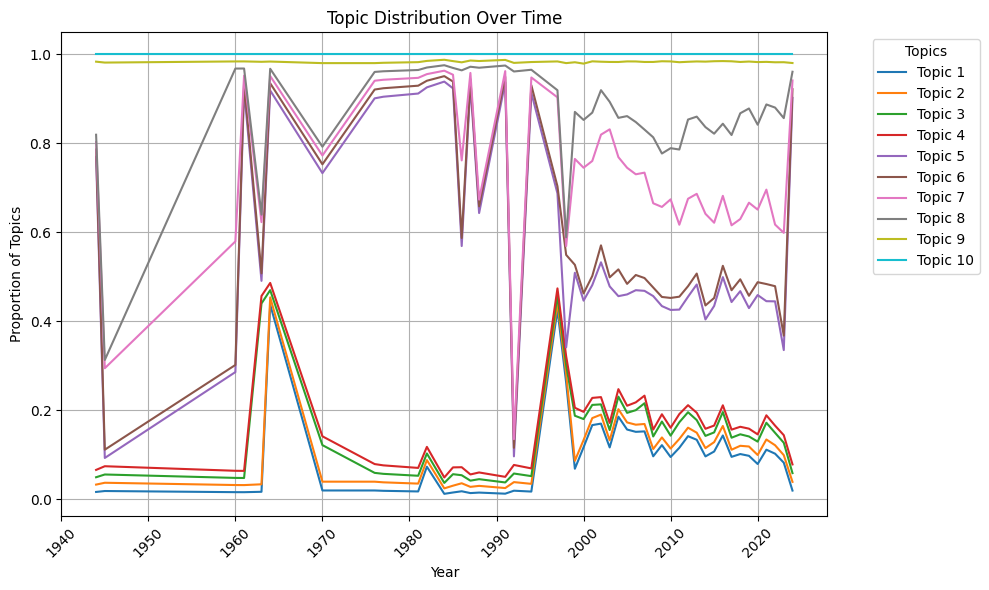

<Figure size 1200x700 with 0 Axes>

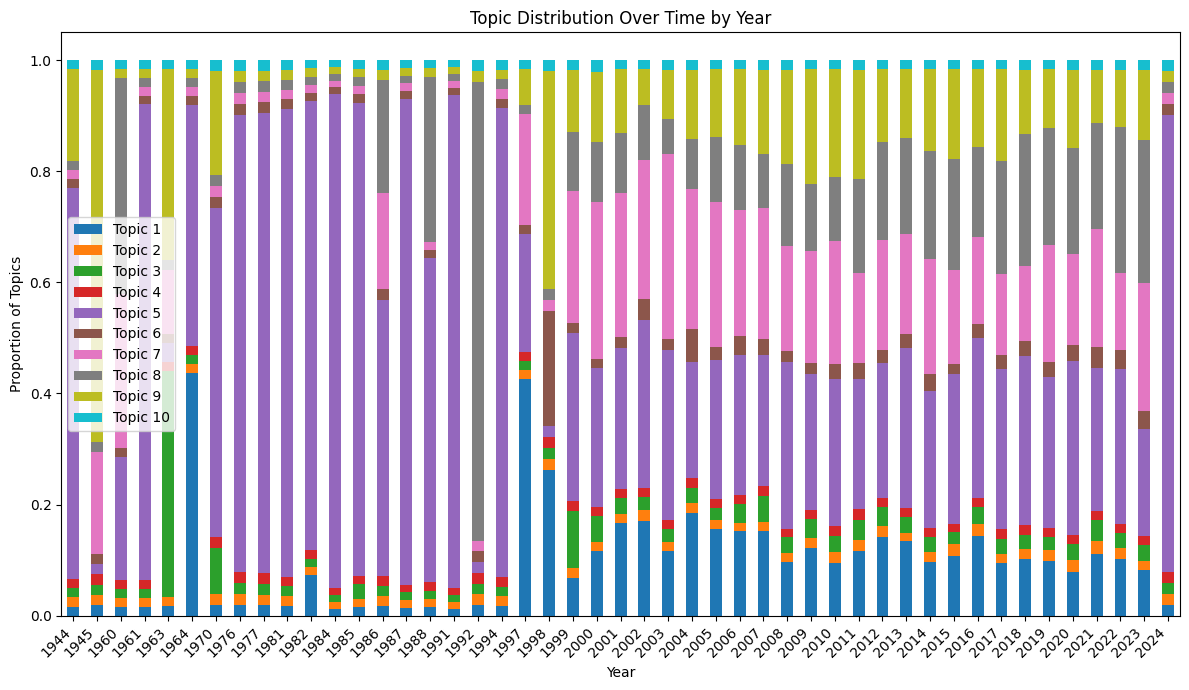

Topic Distribution Over Time (by Year):
       Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7  \
Year                                                                         
1944  0.016515  0.016511  0.016517  0.016511  0.703658  0.016518  0.016521   
1945  0.018591  0.018568  0.018572  0.018578  0.018577  0.018572  0.183080   
1960  0.016023  0.016017  0.016017  0.016017  0.221798  0.016018  0.277628   
1961  0.015961  0.015957  0.015962  0.015957  0.856341  0.015959  0.015978   
1963  0.016854  0.016848  0.406314  0.016847  0.034036  0.016850  0.115124   
1964  0.437440  0.016262  0.016264  0.016262  0.432445  0.016264  0.016267   
1970  0.019808  0.019802  0.082127  0.019806  0.591428  0.019803  0.019812   
1976  0.019792  0.019787  0.019791  0.019787  0.821892  0.019788  0.019791   
1977  0.019064  0.019061  0.019061  0.019061  0.828443  0.019062  0.019063   
1981  0.017630  0.017628  0.017628  0.017628  0.841323  0.017632  0.017635   
1982  0.073252  0.014850

In [ ]:
# Preprocessing: Combine title and abstract into one text column
# Preprocess the text data by combining the title and abstract columns into a single text column
articles_df['Text'] = articles_df['Title'].fillna('') + ' ' + articles_df['Abstract'].fillna('')

# TF-IDF Vectorizer setup
# Set up the TF-IDF vectorizer to convert the text into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf_vectorizer.fit_transform(articles_df['Text'])

# Fit the LDA model (Latent Dirichlet Allocation) with 10 topics
# Train the LDA model with 10 topics
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Get the topic distribution for each document
# Get the topic distribution (probability) for each document in the dataset
topic_distribution = lda.transform(X)  # Probability distribution over topics for each paper

# Group the topic distribution by year and calculate the average for each year
# Group the topic distribution by year and calculate the average topic proportion for each year
articles_df['Year'] = articles_df['Year'].astype(int)  # Ensure year is an integer type
topic_by_year = pd.DataFrame(topic_distribution, columns=[f'Topic {i+1}' for i in range(lda.n_components)])
topic_by_year['Year'] = articles_df['Year']
topic_by_year_grouped = topic_by_year.groupby('Year').mean()  # Average for each year

# Get the top words for each topic
# Extract the top 10 words for each topic based on their weights
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]  # Get top 10 words for each topic
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    topic_words.append(", ".join(top_words))

# Print the topics and their top words
# Display the top words for each topic to interpret its meaning
for i, words in enumerate(topic_words):
    print(f"Topic {i+1}: {words}")

# Plot the topic changes over time
# Plot the change in topic proportions over time (yearly)
plt.figure(figsize=(10, 6))
ax = topic_by_year_grouped.plot(kind='line', stacked=True, figsize=(10, 6))
plt.title('Topic Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Topics')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Improve x-axis label readability
plt.grid(True)
plt.tight_layout()  # Prevent overlap of labels
plt.show()


# Plot the topic changes over time (stacked bar chart)
plt.figure(figsize=(12, 7))
ax = topic_by_year_grouped.plot(kind='bar', stacked=True, figsize=(12, 7))

# Title and labels
plt.title('Topic Distribution Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Topics')
plt.xticks(rotation=45, ha='right')

# Add a legend that shows which topic corresponds to which color
topic_labels = [f"Topic {i+1}: {topic_words[i]}" for i in range(lda.n_components)]
# plt.legend(topic_labels, title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Prevent overlap of labels
plt.show()

# Plot the number of documents per topic
# Count the number of documents for each topic and visualize it
topic_assignment = topic_distribution.argmax(axis=1)  # Assign each document to the most likely topic
topic_counts = pd.Series(topic_assignment).value_counts().sort_index()

# Map the topic numbers to their key words for better understanding
# Map topic numbers to the top words for each topic
topic_labels = [f"Topic {i+1}: {topic_words[i]}" for i in range(len(topic_counts))]


# Display topic distribution by year (topic proportions over time)
print("Topic Distribution Over Time (by Year):")
print(topic_by_year_grouped)

# Display the top words for each topic
print("\nTop Words for Each Topic:")
for i, words in enumerate(topic_words):
    print(f"Topic {i+1}: {words}")

# Display the topic labels (topic names and top words)
print("\nTopic Labels:")
topic_labels = [f"Topic {i+1}: {topic_words[i]}" for i in range(lda.n_components)]
print(topic_labels)

# Display the topic counts per topic
print("\nTopic Counts (Documents per Topic):")
print(topic_counts)

# Display the full topic distribution for each document
print("\nTopic Distribution for Each Document:")
print(topic_distribution)
